In [1]:
pip install numpy scipy matplotlib librosa transformers scikit-learn soundfile openpyxl



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# 1 -- Metadata Mapping

In [23]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



In [24]:
import os
import re

def parse_filename(file_name):
   # Regex with a lookbehind for 'PIN'
    match = re.search(r'(?<=PIN)\d{4}', file_name)
    return int(match.group()) if match else None


def load_metadata(metadata_file_path):
    metadata_df = pd.read_excel(metadata_file_path)
    binary_labels = metadata_df['intake_intake_group'].apply(lambda x: 0 if x == 'ASD' else 1)
    metadata_dict = dict(zip(metadata_df['intake_ldc_pin'].astype(int), binary_labels))
    return metadata_dict


metadata_dict = load_metadata('C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/metadata.xlsx')



In [25]:
print("First few keys and values in metadata_dict:")
for key in list(metadata_dict.keys())[:5]:
    print(f"PIN: {key}, Label: {metadata_dict[key]}")

First few keys and values in metadata_dict:
PIN: 6148, Label: 1
PIN: 9043, Label: 0
PIN: 4475, Label: 1
PIN: 4869, Label: 1
PIN: 9551, Label: 0


# 2 -- Extracting Channels
Out of 509 audio recordings in total. only 322 had two distinct channels (Researcher and Participant) that could successfully be implemented in a DL model.


In [46]:
import os
import soundfile as sf
import librosa

def save_second_channel(audio_path, output_path):
    y, sr = librosa.load(audio_path, sr=None, mono=False)
    
    if y.ndim > 1 and y.shape[0] >= 2:  # Check if audio is multi-channel and has at least two channels
        second_channel = y[1, :]  # Extract the second channel
        sf.write(output_path, second_channel, sr)
    else:
        print(f"File {audio_path} is mono or does not have a second channel.")

root_directory = 'C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles'

for subdir, dirs, files in os.walk(root_directory):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(subdir, file)
            output_path = os.path.join(subdir, file.split('.')[0] + '_second_channel.wav')
            save_second_channel(file_path, output_path)


File C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210507_174823EDT_PIN1099_VBM_SC.wav is mono or does not have a second channel.
File C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210727_173111EDT_PIN1099_VBM_SC.wav is mono or does not have a second channel.
File C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210810_173141EDT_PIN1099_VBM_SC.wav is mono or does not have a second channel.
File C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210824_152621EDT_PIN1099_VBM_SC.wav is mono or does not have a second channel.
File C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1351\20220701_192258EDT_PIN1351_VBM_SC.wav is mono or does not have a second channel.
File C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1351\20220714_211037EDT_PIN1351_VBM_SC.wav is mono or does not have a second channel.
File C:/Users/gerga/OneDrive/Desktop/Uni

In [47]:
import os
import soundfile as sf
import librosa

def save_first_channel(audio_path, output_path):
    y, sr = librosa.load(audio_path, sr=None, mono=False)
    
    if y.ndim > 1 and y.shape[0] >= 2:  # Check if audio is multi-channel and has at least two channels
        first_channel = y[0, :]  # Extract the first channel
        sf.write(output_path, first_channel, sr)
    else:
        print(f"File {audio_path} is mono or does not have a second channel.")

root_directory = 'C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles'

for subdir, dirs, files in os.walk(root_directory):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(subdir, file)
            output_path = os.path.join(subdir, file.split('.')[0] + '_first_channel.wav')
            save_second_channel(file_path, output_path)


File C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210507_153346EDT_PIN1099_VBM_DC-mplex_second_channel.wav is mono or does not have a second channel.
File C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210507_174823EDT_PIN1099_VBM_SC.wav is mono or does not have a second channel.
File C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210720_173139EDT_PIN1099_VBM_DC-mplex_second_channel.wav is mono or does not have a second channel.
File C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210720_173521EDT_PIN1099_VBM_DC-mplex_second_channel.wav is mono or does not have a second channel.
File C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210727_173111EDT_PIN1099_VBM_SC.wav is mono or does not have a second channel.
File C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210803_173121EDT_PIN1099_VBM_DC-mplex_second_channel.wav

# 3 -- Create Mel-spectrograms


After investigating, it has been concluded that audio from the participants was encoded in the second channels consistently througout data collection. Hence, the second channels files would be the only ones receiving the attention of the following procedures

In [16]:
#Mel-spectrograms on second channel

import os
import re
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def extract_date_time_and_pin(file_name):
    match = re.search(r'(\d{8})_(\d{6})[A-Z]{3}_PIN(\d{4})', file_name)
    if match:
        date = match.group(1)
        time = match.group(2)
        pin = match.group(3)
        return date, time, pin
    return None, None, None


def process_and_save_melspectrogram(audio_path, output_path, date, time, pin):
    y, sr = librosa.load(audio_path)
    
    # Custom parameters
    n_fft = 1024  # Length of the FFT window
    hop_length = 320  # Number of samples between successive frames
    n_mels = 64  # Number of Mel bands

    # Generate Mel-spectrogram with custom parameters
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)

    # Save the Mel-spectrogram data as a NumPy file
    np.save(output_path, S_DB)


root_directory = 'C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles'

for subdir, dirs, files in os.walk(root_directory):
    for file in files:
        if file.endswith("_second_channel.wav"):  # Check if the file name ends with '_second_channel.wav'
             date, time, pin = extract_date_time_and_pin(file)
             if date and time and pin:
                file_path = os.path.join(subdir, file)              
                output_filename = f"PIN{pin}_{date}_{time}_melspectrogram_second_channel.npy"
                output_path = os.path.join(subdir, output_filename)
                process_and_save_melspectrogram(file_path, output_path, date, time, pin)

#Final numbers: 322 raw mel spectrograms         

# 4 -- Data Segmentation

Here, new Mel-spectrograms with new values for n_fft, hop_length and n_mels were set, as the spectrogram segments had to reflect the input for the CNN14 model


Furthermore, silent segments are dismissed

In [51]:
import librosa
import numpy as np
import re

def extract_pin_from_filename(file_name):
    match = re.search(r'PIN(\d{4})', file_name)
    return match.group(1) if match else None

def process_audio_file(file_path, segment_length=10, silence_threshold=-76):
    y, sr = librosa.load(file_path, sr=None)
    segment_length_samples = segment_length * sr
    pin = extract_pin_from_filename(file_path)
    mel_specs = []

    for start in range(0, len(y), segment_length_samples):
        end = min(start + segment_length_samples, len(y))
        segment = y[start:end]

        if len(segment) == segment_length_samples:
            mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=1024, hop_length=320, n_mels=64)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

            if np.mean(mel_spec_db) > silence_threshold:
                mel_specs.append((mel_spec_db, pin))  # Append a tuple of Mel-spectrogram and PIN

    return mel_specs

# Example usage
root_directory = 'C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles'
mel_specs_all = []

for subdir, dirs, files in os.walk(root_directory):
    for file in files:
        if file.endswith("_second_channel.wav"):
            file_path = os.path.join(subdir, file)
            mel_specs = process_audio_file(file_path)
            mel_specs_all.extend(mel_specs)
            print(f"Added {len(mel_specs)} segments from {file}")

if mel_specs_all:
    print(f"Total number of segments saved: {len(mel_specs_all)}")
    # Example of accessing a segment and its associated PIN
    sample_segment, sample_pin = mel_specs_all[0]
    print(f"Sample segment's associated PIN: {sample_pin}")
else:
    print("No data saved to mel_specs_all.")


Added 34 segments from 20210507_153346EDT_PIN1099_VBM_DC-mplex_second_channel.wav
Added 2 segments from 20210720_173139EDT_PIN1099_VBM_DC-mplex_second_channel.wav
Added 259 segments from 20210720_173521EDT_PIN1099_VBM_DC-mplex_second_channel.wav
Added 192 segments from 20210803_173121EDT_PIN1099_VBM_DC-mplex_second_channel.wav
Added 192 segments from 20210817_173035EDT_PIN1099_VBM_DC-mplex_second_channel.wav
Added 169 segments from 20210831_172957EDT_PIN1099_VBM_DC-mplex_second_channel.wav
Added 247 segments from 20220622_170055EDT_PIN1351_VBM_DC-mplex_second_channel.wav
Added 196 segments from 20220705_153107EDT_PIN1351_VBM_DC-mplex_second_channel.wav
Added 212 segments from 20220719_161708EDT_PIN1351_VBM_DC-mplex_second_channel.wav
Added 199 segments from 20220802_133053EDT_PIN1351_VBM_DC-mplex_second_channel.wav
Added 4 segments from 20220113_160217EST_PIN2307_VBM_DC-mplex_second_channel.wav
Added 180 segments from 20220113_163044EST_PIN2307_VBM_DC-mplex_second_channel.wav
Added 144

In [52]:
# Print the first few entries in mel_specs_all to see their content
for i, (mel_spec, pin) in enumerate(mel_specs_all[:6]):  # Adjust the number 5 to see more or fewer samples
    print(f"Sample {i+1}:")
    print(f"  PIN: {pin}")
    print(f"  Mel-spectrogram shape: {mel_spec.shape}")
    print(f"  Mel-spectrogram sample data: \n{mel_spec[:, :5]}")  # Print the first few columns for brevity
    print("\n")


Sample 1:
  PIN: 1099
  Mel-spectrogram shape: (64, 251)
  Mel-spectrogram sample data: 
[[-63.71379  -65.26549  -67.94115  -66.531006 -72.8366  ]
 [-68.829605 -66.43366  -70.05931  -76.83042  -80.      ]
 [-73.06364  -66.396965 -71.96798  -76.69     -73.910995]
 [-71.539764 -70.4751   -74.027084 -76.20511  -72.4411  ]
 [-69.82466  -70.590385 -70.62719  -71.01185  -75.04724 ]
 [-74.87812  -70.15029  -66.7703   -70.62168  -75.71526 ]
 [-78.47449  -72.83564  -70.64747  -67.169495 -72.44372 ]
 [-72.00994  -70.09344  -70.022026 -67.79674  -72.15151 ]
 [-71.12204  -68.1854   -69.88192  -72.319984 -73.62405 ]
 [-73.24003  -69.28504  -71.520035 -74.18677  -74.33621 ]
 [-77.93236  -70.67885  -68.95804  -75.19691  -74.21049 ]
 [-77.86886  -68.86455  -72.391624 -78.00026  -74.844345]
 [-77.33289  -72.26975  -74.326744 -74.4385   -76.4183  ]
 [-73.61124  -72.51106  -75.93611  -74.37072  -73.22277 ]
 [-74.299835 -71.49587  -70.91061  -72.95676  -71.59686 ]
 [-74.70466  -71.26284  -75.2282   -75.54

In [53]:
import random

def scale_intensity(mel_spec, factor):
    return mel_spec * factor

augmented_mel_specs = []
for mel_spec, pin in mel_specs_all:
    # Apply augmentation
    factor = random.uniform(0.9, 1.1)  # Random scaling factor between 0.9 and 1.1
    augmented_spec = scale_intensity(mel_spec, factor)
    augmented_mel_specs.append((augmented_spec, pin))


In [54]:
def normalize_mel_spec(mel_spec):
    mean = np.mean(mel_spec)
    std = np.std(mel_spec)
    return (mel_spec - mean) / std if std > 0 else mel_spec

normalized_mel_specs = []
for mel_spec, pin in augmented_mel_specs:
    normalized_spec = normalize_mel_spec(mel_spec)
    normalized_mel_specs.append((normalized_spec, pin))


# 6 -- Data Normalization

In [55]:
normalized_mel_specs_with_labels = []

for mel_spec, pin in normalized_mel_specs:
    label = metadata_dict.get(int(pin))  # Retrieve the label using the PIN
    if label is not None:
        normalized_mel_specs_with_labels.append((mel_spec, label))
    else:
        print(f"Label not found for PIN: {pin}")


# 7 -- Split into train and test

In [57]:
from sklearn.model_selection import train_test_split

X = np.array([mel_spec for mel_spec, label in normalized_mel_specs_with_labels])
y = np.array([label for mel_spec, label in normalized_mel_specs_with_labels])

# Reshape for CNN input (adding a channel dimension)
X = X[..., np.newaxis]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



# Plain CNN

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(X_train.shape[1:])),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [59]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
996/996 [==============================] - 157s 156ms/step - loss: 0.6868 - accuracy: 0.5723 - val_loss: 0.6818 - val_accuracy: 0.5747
Epoch 2/10
996/996 [==============================] - 153s 153ms/step - loss: 0.6829 - accuracy: 0.5725 - val_loss: 0.6828 - val_accuracy: 0.5721
Epoch 3/10
996/996 [==============================] - 166s 166ms/step - loss: 0.6827 - accuracy: 0.5726 - val_loss: 0.6806 - val_accuracy: 0.5749
Epoch 4/10
996/996 [==============================] - 192s 193ms/step - loss: 0.6816 - accuracy: 0.5740 - val_loss: 0.6862 - val_accuracy: 0.5677
Epoch 5/10
996/996 [==============================] - 190s 191ms/step - loss: 0.6702 - accuracy: 0.5839 - val_loss: 0.6550 - val_accuracy: 0.6071
Epoch 6/10
996/996 [==============================] - 199s 200ms/step - loss: 0.6371 - accuracy: 0.6255 - val_loss: 0.6147 - val_accuracy: 0.6414
Epoch 7/10
996/996 [==============================] - 216s 217ms/step - loss: 0.6039 - accuracy: 0.6560 - val_loss: 0.5980 -

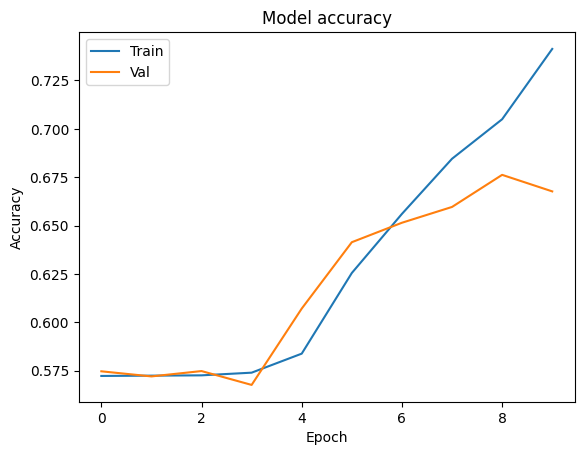

In [61]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [62]:
predictions = model.predict(X_val)

249/249 [==============================] - 8s 31ms/step


In [63]:
predicted_classes = [1 if prob > 0.5 else 0 for prob in predictions]

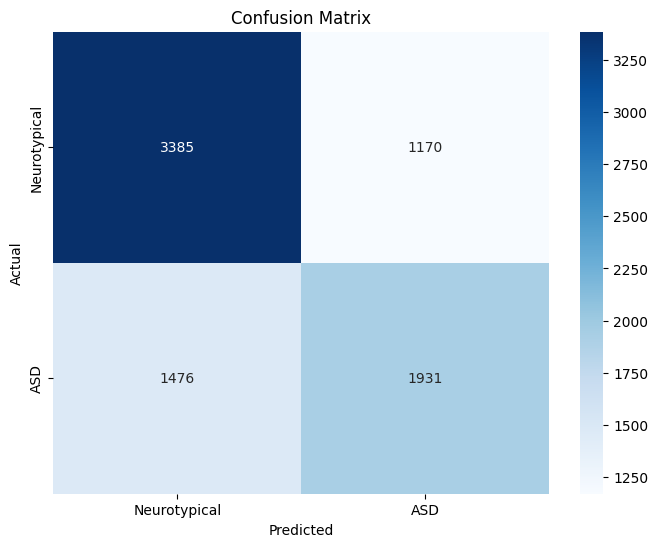

In [64]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neurotypical", "ASD"], yticklabels=["Neurotypical", "ASD"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_val, predicted_classes)
precision = precision_score(y_val, predicted_classes)
recall = recall_score(y_val, predicted_classes)
f1 = f1_score(y_val, predicted_classes)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 0.69819140919367
Precision: 0.6622495151906916
Recall: 0.6014088641033167
F1 Score: 0.6303645592985694


In [11]:
import os
import librosa

def find_and_check_sample_rates(root_dir):
    sample_rates = {}

    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Filter and process files ending with '_second_channel.wav'
        for filename in [f for f in filenames if f.endswith('_second_channel.wav')]:
            full_path = os.path.join(dirpath, filename)
            # Load the audio file with librosa
            _, sr = librosa.load(full_path, sr=None)  # Load with original sample rate
            sample_rates[full_path] = sr
    
    return sample_rates

root_directory = 'C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles'
sample_rates = find_and_check_sample_rates(root_directory)

for filepath, sr in sample_rates.items():
    print(f"File: {filepath} has a sample rate of: {sr} Hz")


File: C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210507_153346EDT_PIN1099_VBM_DC-mplex_second_channel.wav has a sample rate of: 8000 Hz
File: C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210720_173139EDT_PIN1099_VBM_DC-mplex_second_channel.wav has a sample rate of: 8000 Hz
File: C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210720_173521EDT_PIN1099_VBM_DC-mplex_second_channel.wav has a sample rate of: 8000 Hz
File: C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210803_173121EDT_PIN1099_VBM_DC-mplex_second_channel.wav has a sample rate of: 8000 Hz
File: C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210817_173035EDT_PIN1099_VBM_DC-mplex_second_channel.wav has a sample rate of: 8000 Hz
File: C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210831_172957EDT_PIN1099_VBM_DC-mplex_second_channel.wav has a sample rat

In [12]:
import os
import librosa
import soundfile as sf

def resample_audio(file_path, target_sr):
    audio, original_sr = librosa.load(file_path, sr=None)
    audio_resampled = librosa.resample(audio, orig_sr=original_sr, target_sr=target_sr)
    new_file_path = file_path.replace('.wav', '_resampled.wav')
    sf.write(new_file_path, audio_resampled, target_sr)
    
    return new_file_path

def resample_directory_audio(root_dir, target_sr):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in [f for f in filenames if f.endswith('_second_channel.wav')]:
            full_path = os.path.join(dirpath, filename)
            print(f"Resampling: {full_path}")
            # Resample the audio file
            new_file_path = resample_audio(full_path, target_sr)
            print(f"Resampled audio saved to: {new_file_path}")

root_directory = 'C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles'
target_sr = 16000 

resample_directory_audio(root_directory, target_sr)


Resampling: C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210507_153346EDT_PIN1099_VBM_DC-mplex_second_channel.wav
Resampled audio saved to: C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210507_153346EDT_PIN1099_VBM_DC-mplex_second_channel_resampled.wav
Resampling: C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210720_173139EDT_PIN1099_VBM_DC-mplex_second_channel.wav
Resampled audio saved to: C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210720_173139EDT_PIN1099_VBM_DC-mplex_second_channel_resampled.wav
Resampling: C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210720_173521EDT_PIN1099_VBM_DC-mplex_second_channel.wav
Resampled audio saved to: C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles\pin #1099\20210720_173521EDT_PIN1099_VBM_DC-mplex_second_channel_resampled.wav
Resampling: C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA p

In [13]:
def collect_file_paths(root_dir, suffix='_resampled.wav'):
    file_paths = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith(suffix):
                full_path = os.path.join(dirpath, filename)
                file_paths.append(full_path)
    return file_paths

root_directory = 'C:/Users/gerga/OneDrive/Desktop/Uni/5 sem/BA project/audioFiles'
file_paths = collect_file_paths(root_directory)


In [14]:
import tensorflow as tf

def load_audio(file_path):
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    return audio  # No squeeze operation since the files are mono-channel

def create_dataset(file_paths):
    path_dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    audio_dataset = path_dataset.map(lambda x: load_audio(x))
    return audio_dataset


dataset = create_dataset(file_paths)

for item in dataset.take(5):  # Just taking the first 5 for demonstration
    print(item.shape)



(5566400, 1)
(438400, 1)
(41525760, 1)
(30908160, 1)
(30833920, 1)


In [15]:
def extract_yamnet_features(audio):
    # YAMNet expects a 1D tensor of audio samples
    audio = tf.squeeze(audio, axis=-1)  # Ensure audio is 1D (remove channel dimension)
    
    # Extract embeddings
    _, embeddings, _ = yamnet_model(audio)
    return embeddings


In [16]:
# Map the feature extraction function
features_dataset = dataset.map(lambda x: extract_yamnet_features(x))


In [17]:
features_dataset = dataset.map(extract_yamnet_features)


In [19]:
for features in features_dataset.take(3):  # Take 3 for testing
    print(features.numpy().shape)


(724, 1024)
(57, 1024)
(5406, 1024)


In [27]:
# Assuming `file_paths` is a list of paths to your audio files
# and `features` is a list or array of extracted features

# Extract PINs and map them to labels
pins = [parse_filename(os.path.basename(path)) for path in file_paths]
labels = [metadata_dict[pin] for pin in pins if pin in metadata_dict]


In [28]:
# Filter features where PINs were successfully extracted and found in metadata
filtered_features = [feature for feature, pin in zip(features, pins) if pin in metadata_dict]


In [29]:
# Convert features and labels into a TensorFlow dataset
features_and_labels_dataset = tf.data.Dataset.from_tensor_slices((filtered_features, labels))


In [30]:
# Shuffle and batch the dataset
shuffled_dataset = features_and_labels_dataset.shuffle(buffer_size=10000)
batched_dataset = shuffled_dataset.batch(32)


In [31]:
# Calculate the number of samples in each set
total_size = len(labels)  # Assuming `labels` is a list of your labels
train_size = int(0.8 * total_size)
test_size = total_size - train_size

# Split the dataset
train_dataset = shuffled_dataset.take(train_size)
test_dataset = shuffled_dataset.skip(train_size)


In [32]:
batch_size = 32  # You can adjust the batch size according to your needs

train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


In [42]:

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight=sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight=sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Define your model architecture here
model = tf.keras.Sequential([
    # Add your model layers, for example:
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Adjust based on your task
])



# Compile the model with additional metrics
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), F1Score()])


# Train the model
model.fit(train_dataset, validation_data=test_dataset, epochs=10)


Epoch 1/10


1/9 [==>...........................] - ETA: 7s - loss: 0.6849 - accuracy: 0.5938 - recall_7: 0.9286 - precision_7: 0.5200 - f1_score: 0.6667

C:\Users\gerga\python3.10\Lib\site-packages\keras\engine\training.py:2416: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


9/9 [==============================] - 1s 36ms/step - loss: 1.3581 - accuracy: 0.5253 - recall_7: 0.3305 - precision_7: 0.4756 - f1_score: 0.3900 - val_loss: 1.4026 - val_accuracy: 0.6308 - val_recall_7: 0.2500 - val_precision_7: 0.7000 - val_f1_score: 0.3684
Epoch 2/10
9/9 [==============================] - 0s 9ms/step - loss: 1.0525 - accuracy: 0.5292 - recall_7: 0.5966 - precision_7: 0.4931 - f1_score: 0.5399 - val_loss: 0.7602 - val_accuracy: 0.6308 - val_recall_7: 0.3571 - val_precision_7: 0.6250 - val_f1_score: 0.4545
Epoch 3/10
9/9 [==============================] - 0s 10ms/step - loss: 1.2011 - accuracy: 0.5525 - recall_7: 0.3884 - precision_7: 0.5341 - f1_score: 0.4498 - val_loss: 0.6982 - val_accuracy: 0.5385 - val_recall_7: 0.7241 - val_precision_7: 0.4884 - val_f1_score: 0.5833
Epoch 4/10
9/9 [==============================] - 0s 8ms/step - loss: 0.8794 - accuracy: 0.5953 - recall_7: 0.5763 - precision_7: 0.5574 - f1_score: 0.5667 - val_loss: 0.9356 - val_accuracy: 0.5692 -

In [43]:
test_loss, test_accuracy, test_recall, test_precision, test_f1_score = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Recall: {test_recall}")
print(f"Test Precision: {test_precision}")
print(f"Test F1 Score: {test_f1_score}")


3/3 [==============================] - 0s 6ms/step - loss: 0.5882 - accuracy: 0.7231 - recall_7: 0.6000 - precision_7: 0.7500 - f1_score: 0.6667
Test Loss: 0.5882050395011902
Test Accuracy: 0.7230769395828247
Test Recall: 0.6000000238418579
Test Precision: 0.75
Test F1 Score: 0.6666666269302368


In [44]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Adjust based on your task
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), F1Score()])
    return model


In [48]:
# Assuming test_dataset is your test data
test_features, test_labels = zip(*test_dataset.unbatch())  # Unbatch the dataset if batched
test_features = np.array(test_features)
test_labels = np.array(test_labels)

# Get model predictions
predictions = model.predict(test_features)
# Convert probabilities to binary predictions
binary_predictions = np.round(predictions).astype(int).flatten()  # Adjust based on your specific needs


3/3 [==============================] - 0s 2ms/step


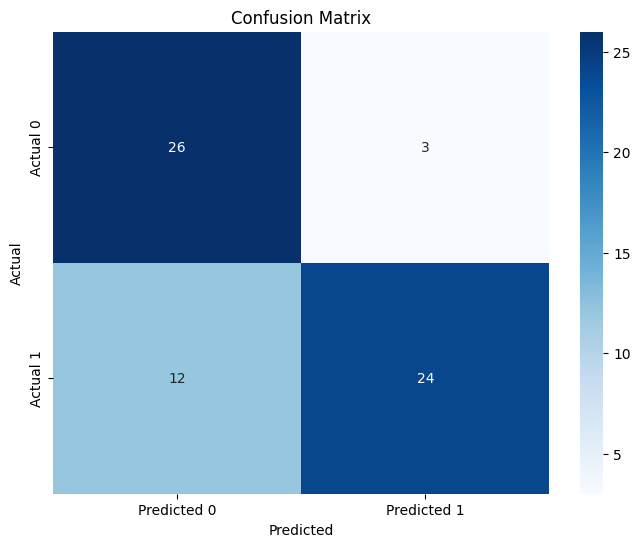

In [49]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(test_labels, binary_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
